<a href="https://colab.research.google.com/github/Apikmmar/term-deposit-prediction/blob/main/project_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import sys
!{sys.executable} -m pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
!pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os

In [15]:
%cd "/content/drive/MyDrive/bank-marketing"

/content/drive/MyDrive/bank-marketing


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
import pandas as pd

from skfuzzy import control as ctrl
from numpy import genfromtxt

In [17]:
dataset = pd.read_csv('bank-additional-full.csv', sep=',')
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [18]:
del dataset['age']
del dataset['job']
del dataset['marital']
del dataset['education']
del dataset['default']
del dataset['contact']
del dataset['month']
del dataset['pdays']
del dataset['duration']
del dataset['day_of_week']
del dataset['campaign']
del dataset['previous']
del dataset['poutcome']
del dataset['nr.employed']
del dataset['emp.var.rate']
del dataset['cons.conf.idx']


print(dataset.columns.tolist())

['housing', 'loan', 'cons.price.idx', 'euribor3m', 'y']


In [19]:
dataset['housing'] = dataset['housing'].map({
    'yes': 1,
    'unknown': 0.5,
    'no': 0
})

dataset['loan'] = dataset['loan'].map({
    'yes': 1,
    'unknown': 0.5,
    'no': 0
})

dataset['y'] = dataset['y'].map({
    'yes': 1,
    'no': 0
})

In [21]:
housing = ctrl.Antecedent(np.arange(-1, 1, 0.5), 'housing')
loan = ctrl.Antecedent(np.arange(-1, 1, 0.5), 'loan')
cpi = ctrl.Antecedent(np.arange(dataset['cons.price.idx'].min(), dataset['cons.price.idx'].max(), 1), 'cons.price.idx')
epi = ctrl.Antecedent(np.arange(dataset['euribor3m'].min(), dataset['euribor3m'].max(), 1), 'euribor3m')
subs = ctrl.Consequent(np.arange(dataset['y'].min(), dataset['y'].max(), 0.5), 'y', defuzzify_method='centroid')

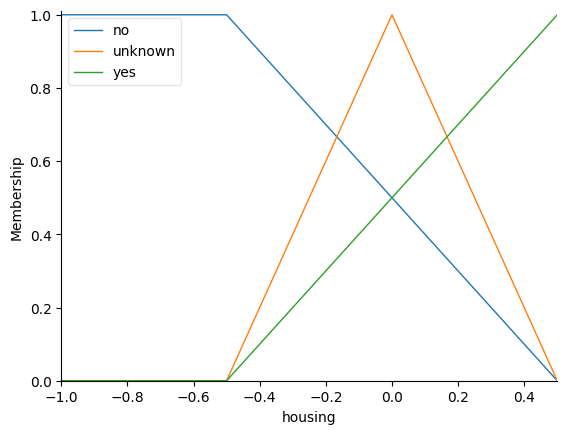

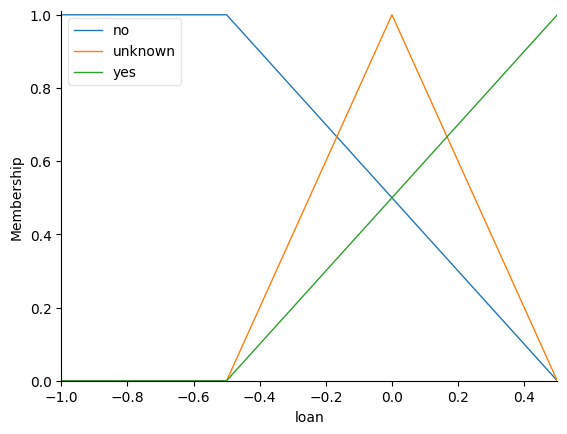

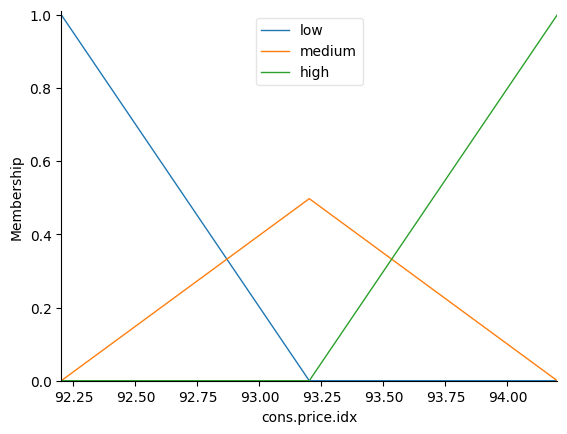

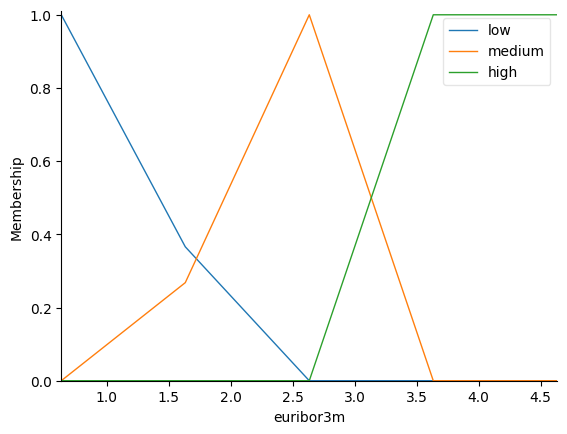

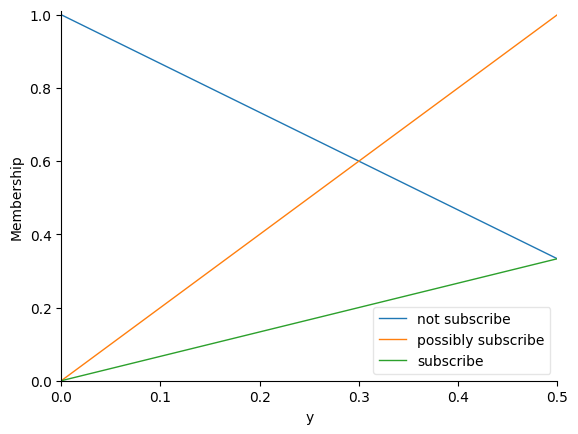

In [22]:
housing['no'] = fuzz.trapmf(housing.universe, [-1, -1, -0.3, 0.3])
housing['unknown'] = fuzz.trimf(housing.universe, [-0.5, 0, 0.5])
housing['yes'] = fuzz.trapmf(housing.universe, [-0.3, 0.3, 1, 1])

loan['no'] = fuzz.trapmf(loan.universe, [-1, -1, -0.3, 0.3])
loan['unknown'] = fuzz.trimf(loan.universe, [-0.5, 0, 0.5])
loan['yes'] = fuzz.trapmf(loan.universe, [-0.3, 0.3, 1, 1])

cpi['low'] = fuzz.trapmf(cpi.universe, [92., 92., 92.5, 92.8])
cpi['medium'] = fuzz.trimf(cpi.universe, [92.8, 93.0, 93.4])
cpi['high'] = fuzz.trapmf(cpi.universe, [93.4, 94., dataset['cons.price.idx'].max(), dataset['cons.price.idx'].max()])

epi['low'] = fuzz.trapmf(epi.universe, [0, 0, 1., 2.])
epi['medium'] = fuzz.trapmf(epi.universe, [1.5, 2., 3., 3.5])
epi['high'] = fuzz.trapmf(epi.universe, [3., 3.5, dataset['euribor3m'].max(), dataset['euribor3m'].max()])

subs['not subscribe'] = fuzz.trapmf(subs.universe, [0, 0, 0.3, 0.6])
subs['possibly subscribe'] = fuzz.trapmf(subs.universe, [0.4, 0.45, 0.55, 0.6])
subs['subscribe'] = fuzz.trapmf(subs.universe, [0.4, 0.7, 1.0, 1.0])

housing.view()
loan.view()
cpi.view()
epi.view()
subs.view()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

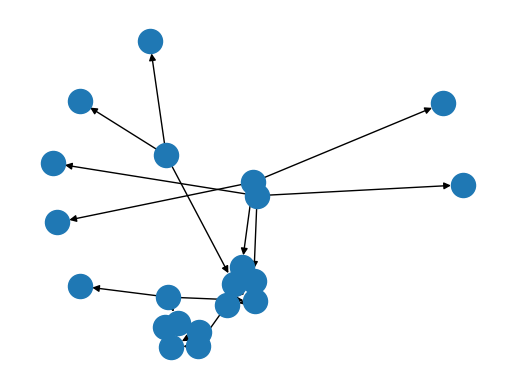

In [25]:
rule1 = ctrl.Rule(housing['no'] & loan['no'] & cpi['low'] & epi['low'], subs['not subscribe'])

subs_ctrl = ctrl.ControlSystem([
    rule1,
    ctrl.Rule(housing['no'] & loan['no'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['high'] & epi['medium'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['no'] & loan['yes'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['high'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['high'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['yes'] & loan['no'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['high'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['high'] & epi['medium'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['high'] & epi['high'], subs['not subscribe']),
])

subs_predict = ctrl.ControlSystemSimulation(subs_ctrl)

rule1.view()